## Packagek

In [1]:
import dill
import pickle
from google.colab import drive, files
from urllib.request import urlopen

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from tensorflow.keras import applications


from sklearn.metrics import pairwise_distances
import requests
from PIL import Image, ImageFile

## Adatok

In [9]:
drive.mount('/content/drive')
filepath = '/content/drive/My Drive/MLkurzus/Beadandó/session.pkl'
#filepath = '/content/drive/My Drive/ML_kurzus_projekt/session.pkl'
dill.load_session(filepath) # Load the session

Mounted at /content/drive


In [10]:
df

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
43,0061099686,Downtown,Anne Rivers Siddons,1995,HarperTorch,"[[[164, 196, 221], [176, 200, 226], [183, 204,...",http://images.amazon.com/images/P/0061099686.0...,http://images.amazon.com/images/P/0061099686.0...
131,9724119378,O Deus Das Pequenas Coisas,Roy,1998,Edicoes Asa,[[1]],http://images.amazon.com/images/P/9724119378.0...,http://images.amazon.com/images/P/9724119378.0...
209,0345433173,The Tall Pine Polka,Lorna Landvik,1999,Ballantine Books,"[[[10, 53, 60], [9, 54, 60], [6, 55, 60], [5, ...",http://images.amazon.com/images/P/0345433173.0...,http://images.amazon.com/images/P/0345433173.0...
299,1563898586,"The League of Extraordinary Gentlemen, Vol. 1",Alan Moore,2002,DC Comics,"[[[151, 142, 113], [142, 133, 104], [153, 142,...",http://images.amazon.com/images/P/1563898586.0...,http://images.amazon.com/images/P/1563898586.0...
323,0380728729,Babyhood,Paul Reiser,1998,Avon,"[[[254, 255, 250], [254, 255, 250], [254, 255,...",http://images.amazon.com/images/P/0380728729.0...,http://images.amazon.com/images/P/0380728729.0...
...,...,...,...,...,...,...,...,...
271189,0425127486,Hardshell (Originally Published As Night Visio...,Clive Barker,1990,Berkley Pub Group,[[1]],http://images.amazon.com/images/P/0425127486.0...,http://images.amazon.com/images/P/0425127486.0...
271192,0394727959,The Wine of Astonishment (Aventura),Earl Lovelace,1984,Random House Inc,[[1]],http://images.amazon.com/images/P/0394727959.0...,http://images.amazon.com/images/P/0394727959.0...
271261,0310232546,"Ask Lily (Young Women of Faith: Lily Series, ...",Nancy N. Rue,2001,Zonderkidz,"[[[8, 7, 12], [8, 7, 12], [8, 7, 12], [8, 7, 1...",http://images.amazon.com/images/P/0310232546.0...,http://images.amazon.com/images/P/0310232546.0...
271279,1562477900,Amelia Hits the Road (Amelia),Marissa Moss,1999,Pleasant Company Publications,"[[[4, 13, 20], [0, 14, 23], [0, 16, 26], [7, 1...",http://images.amazon.com/images/P/1562477900.0...,http://images.amazon.com/images/P/1562477900.0...


In [11]:
pics = df

In [12]:
pics = pics.reset_index()

In [13]:
# itt ami nem jó formátumú azt kiszedtem, mert máshogy nem voltjó

torolni = []

for i in range(10000):
  if type(pics['Image-URL-S'][i]) == int:
    torolni.append(i)
  if type(pics['Image-URL-S'][i]) != int and len(pics['Image-URL-S'][i].shape) != 3:
    torolni.append(i)

pics = pics.drop(labels = torolni, axis = 0)

In [14]:
pics = pics.reset_index()

In [15]:
pics = pics.drop(labels=['Image-URL-M', 'Image-URL-L', 'Publisher', 'Book-Author', 'Year-Of-Publication'], axis = 1)

## VGG16 betöltése

In [16]:
vgg_model =applications.vgg16.VGG16(include_top=True,
    weights="imagenet",
    input_shape=(224, 224, 3))

In [17]:
type(vgg_model)

keras.engine.functional.Functional

In [54]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Feature map

In [19]:
vgg_model.layers

In [20]:
conv_layers = []
conv_layers_id = []

for i, layer in enumerate(vgg_model.layers):
    if 'conv' in layer.name:
        conv_layers.append(layer)
        conv_layers_id.append(i)

outputs = []

for layer_id in conv_layers_id:
    outputs.append(vgg_model.layers[layer_id].output)

In [21]:
len(conv_layers)

13

## Image preprocessing

In [22]:
def kepformazas(kep):
  kep = kep.resize((224,224))
  kep = np.asarray(kep)
  kep = kep.reshape((1, kep.shape[0], kep.shape[1], kep.shape[2]))
  kep = preprocess_input(kep)
  return kep

## Feature map távolságok

In [23]:
extracted_features = []

for i in range(6390):
  image = kepformazas(Image.fromarray(pics['Image-URL-S'][i]))
  model = keras.Model(inputs=vgg_model.inputs, outputs=outputs)
  extracted_features.append(vgg_model.predict_generator(image, 1 // 1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  


KeyboardInterrupt: ignored

In [ ]:
len(extracted_features)

6390

In [ ]:
min_index = []

for j in range(6390):
  min_dist = 100
  min_indexes = []

  for i in range(6390):

    dist = pairwise_distances(extracted_features[j], extracted_features[i].reshape(1,-1))

    if dist < min_dist and dist != 0:

      min_dist = dist
      min_indexes.append(i)

  min_index.append(min_indexes[-1])

In [ ]:
len(min_index)

6390

In [ ]:
pics['recomm_index'] = min_index

In [ ]:
pics

,level_0,index,ISBN,Book-Title,Image-URL-S,recomm_index
0,0,43,0061099686,Downtown,"[[[164, 196, 221], [176, 200, 226], [183, 204,...",2939
1,2,209,0345433173,The Tall Pine Polka,"[[[10, 53, 60], [9, 54, 60], [6, 55, 60], [5, ...",1
2,3,299,1563898586,"The League of Extraordinary Gentlemen, Vol. 1","[[[151, 142, 113], [142, 133, 104], [153, 142,...",3671
3,4,323,0380728729,Babyhood,"[[[254, 255, 250], [254, 255, 250], [254, 255,...",3
4,5,349,0771088191,The Best Canadian Animal Stories: Classic Tale...,"[[[254, 255, 255], [254, 255, 255], [254, 255,...",4
...,...,...,...,...,...,...
6385,9993,271176,0786841672,Ariel's Treasure Hunt (Disney First Readers. L...,"[[[255, 228, 12], [255, 241, 38], [247, 225, 1...",4418
6386,9994,271186,0152021345,Weird Stories from the Lonesome CafÂ¿,"[[[253, 242, 134], [253, 242, 136], [255, 241,...",6386
6387,9997,271261,0310232546,"Ask Lily (Young Women of Faith: Lily Series, ...","[[[8, 7, 12], [8, 7, 12], [8, 7, 12], [8, 7, 1...",320
6388,9998,271279,1562477900,Amelia Hits the Road (Amelia),"[[[4, 13, 20], [0, 14, 23], [0, 16, 26], [7, 1...",4285


In [ ]:
pics = pics.drop(labels=['index', 'level_0'], axis = 1)

In [ ]:
pics.to_csv('/content/drive/My Drive/MLkurzus/Beadandó/borito_ajanlo.csv')

Próba + ábra

In [24]:
df = pd.read_csv('/content/drive/My Drive/MLkurzus/Beadandó/borito_ajanlo.csv')

In [25]:
df

,Unnamed: 0,ISBN,Book-Title,Image-URL-S,recomm_index
0,0,0061099686,Downtown,[[[164 196 221]\n [176 200 226]\n [183 204 2...,2939
1,1,0345433173,The Tall Pine Polka,[[[ 10 53 60]\n [ 9 54 60]\n [ 6 55 ...,1
2,2,1563898586,"The League of Extraordinary Gentlemen, Vol. 1",[[[151 142 113]\n [142 133 104]\n [153 142 1...,3671
3,3,0380728729,Babyhood,[[[254 255 250]\n [254 255 250]\n [254 255 2...,3
4,4,0771088191,The Best Canadian Animal Stories: Classic Tale...,[[[254 255 255]\n [254 255 255]\n [254 255 2...,4
...,...,...,...,...,...
6385,6385,0786841672,Ariel's Treasure Hunt (Disney First Readers. L...,[[[255 228 12]\n [255 241 38]\n [247 225 ...,4418
6386,6386,0152021345,Weird Stories from the Lonesome CafÂ¿,[[[253 242 134]\n [253 242 136]\n [255 241 1...,6386
6387,6387,0310232546,"Ask Lily (Young Women of Faith: Lily Series, ...",[[[ 8 7 12]\n [ 8 7 12]\n [ 8 7 ...,320
6388,6388,1562477900,Amelia Hits the Road (Amelia),[[[ 4 13 20]\n [ 0 14 23]\n [ 0 16 ...,4285


In [43]:
konyv = 139
konyvcim = pics['Book-Title'][konyv]
konyvcim2 = pics['Book-Title'][[df['recomm_index'][konyv]]]
print(konyvcim,konyvcim2)

Blow Fly: A Scarpetta Novel 765    A Little Yellow Dog: An Easy Rawlins Mystery (...
Name: Book-Title, dtype: object


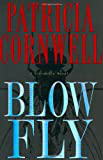

In [44]:
Image.fromarray(pics['Image-URL-S'][konyv])

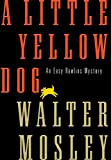

In [45]:
Image.fromarray(pics['Image-URL-S'][df['recomm_index'][konyv]])

In [48]:
konyvcim2

765    A Little Yellow Dog: An Easy Rawlins Mystery (...
Name: Book-Title, dtype: object

Text(0.5, 1.0, 'A Little Yellow Dog:\n An Easy Rawlins Mystery')

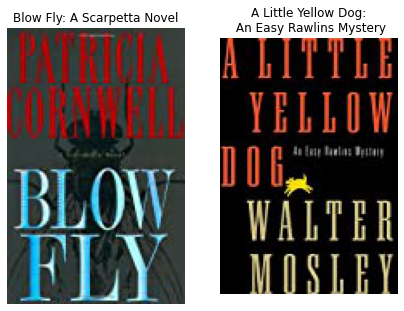

In [52]:
fig = plt.figure(figsize=(7, 7))

rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.imshow(Image.fromarray(pics['Image-URL-S'][konyv]))
plt.axis('off')
plt.title(konyvcim)
  
fig.add_subplot(rows, columns, 2)
plt.imshow(Image.fromarray(pics['Image-URL-S'][df['recomm_index'][konyv]]))
plt.axis('off')
plt.title('A Little Yellow Dog:\n An Easy Rawlins Mystery')